In [1]:
import numpy as np
import cv2 as cv
import imutils
from matplotlib import pyplot as plt

img = cv.imread('G-Cili-1.jpg')
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
sat = hsv[:,:,1]

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.figure(figsize=(12, 9))

plt.subplot(121)
plt.title("Saturation channel (HSV)")
plt.imshow(sat, cmap='gray')

plt.subplot(122)
plt.title("Histogram")
plt.hist(sat.ravel(), 256)

plt.show()

<Figure size 1200x900 with 2 Axes>

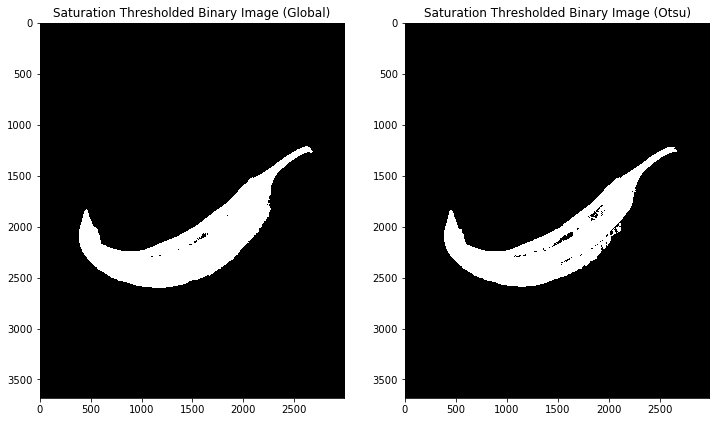

In [2]:
sat_blurred = cv.medianBlur(sat, 5)
ret, global_thresh = cv.threshold(sat_blurred, 50, 255, cv.THRESH_BINARY)
ret, otsu_thresh = cv.threshold(sat_blurred, 0, 255, cv.THRESH_OTSU)

plt.figure(figsize=(12, 9))

plt.subplot(121)
plt.title("Saturation Thresholded Binary Image (Global)")
plt.imshow(global_thresh, cmap='gray')

plt.subplot(122)
plt.title("Saturation Thresholded Binary Image (Otsu)")
plt.imshow(otsu_thresh, cmap='gray')

plt.show()

sat_thresh = global_thresh

#print("Min: " + str(np.min(thresh)))
#print("Max: " + str(np.max(thresh)))

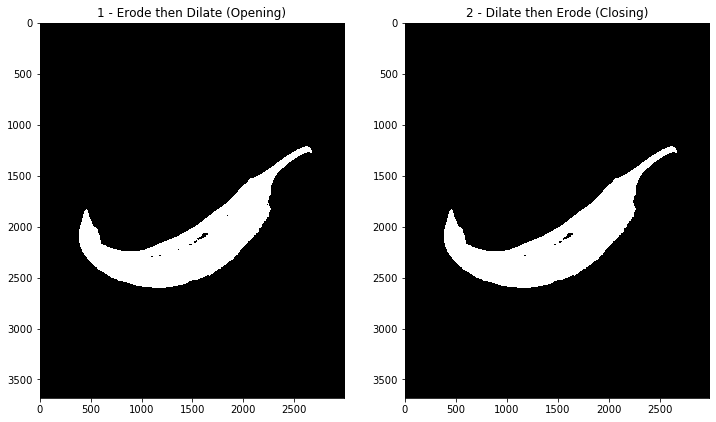

In [3]:
# Noise Removal
kernel = np.ones((5, 5), np.uint8)

opening = cv.morphologyEx(sat_thresh, cv.MORPH_OPEN, kernel, iterations=2)
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel, iterations=2)

plt.figure(figsize=(12, 9))

plt.subplot(121)
plt.title("1 - Erode then Dilate (Opening)")
plt.imshow(opening, cmap='gray')

plt.subplot(122)
plt.title("2 - Dilate then Erode (Closing)")
plt.imshow(closing, cmap='gray')

plt.show()

sat_final = closing

## Working in LAB Colourspace

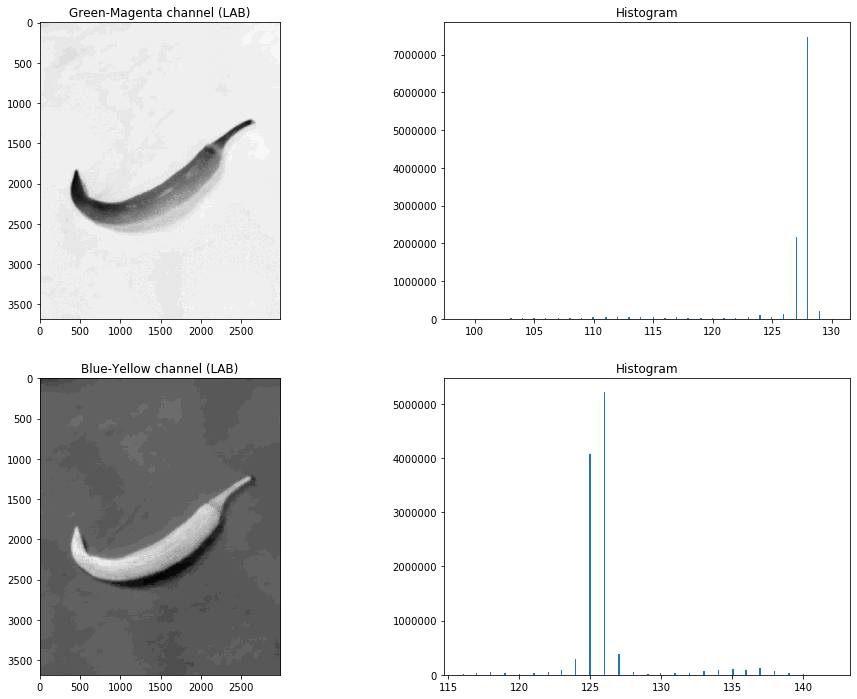

In [4]:
lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
gm = lab[:,:,1]
by = lab[:,:,2]

plt.figure(figsize=(16, 12))

plt.subplot(221)
plt.title("Green-Magenta channel (LAB)")
plt.imshow(gm, cmap='gray')

plt.subplot(222)
plt.title("Histogram")
plt.hist(gm.ravel(), 256)

plt.subplot(223)
plt.title("Blue-Yellow channel (LAB)")
plt.imshow(by, cmap='gray')

plt.subplot(224)
plt.title("Histogram")
plt.hist(by.ravel(), 256)

plt.show()

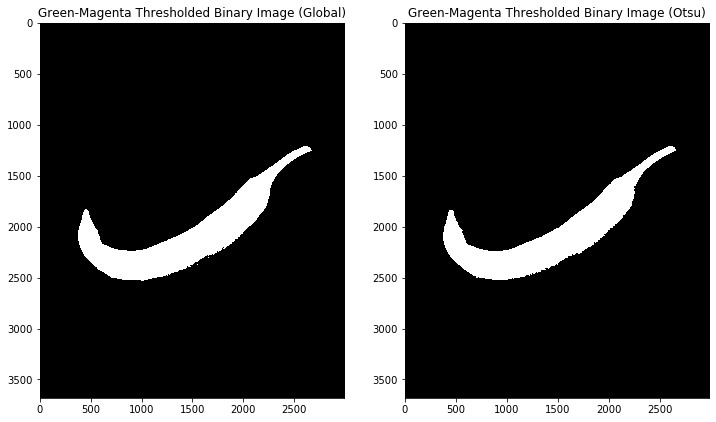

In [5]:
gm_blurred = cv.medianBlur(gm, 5)
ret, global_thresh = cv.threshold(gm_blurred, 120, 255, cv.THRESH_BINARY_INV)
ret, otsu_thresh = cv.threshold(gm_blurred, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

plt.figure(figsize=(12, 9))

plt.subplot(121)
plt.title("Green-Magenta Thresholded Binary Image (Global)")
plt.imshow(global_thresh, cmap='gray')

plt.subplot(122)
plt.title("Green-Magenta Thresholded Binary Image (Otsu)")
plt.imshow(otsu_thresh, cmap='gray')

plt.show()
gm_thresh = global_thresh

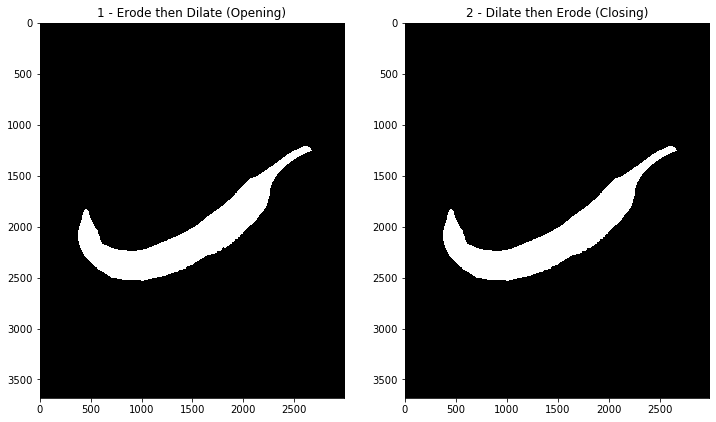

In [6]:
# Noise Removal
kernel = np.ones((5, 5), np.uint8)

opening = cv.morphologyEx(gm_thresh, cv.MORPH_OPEN, kernel, iterations=2)
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel, iterations=2)

plt.figure(figsize=(12, 9))

plt.subplot(121)
plt.title("1 - Erode then Dilate (Opening)")
plt.imshow(opening, cmap='gray')

plt.subplot(122)
plt.title("2 - Dilate then Erode (Closing)")
plt.imshow(closing, cmap='gray')

plt.show()

gm_final = closing

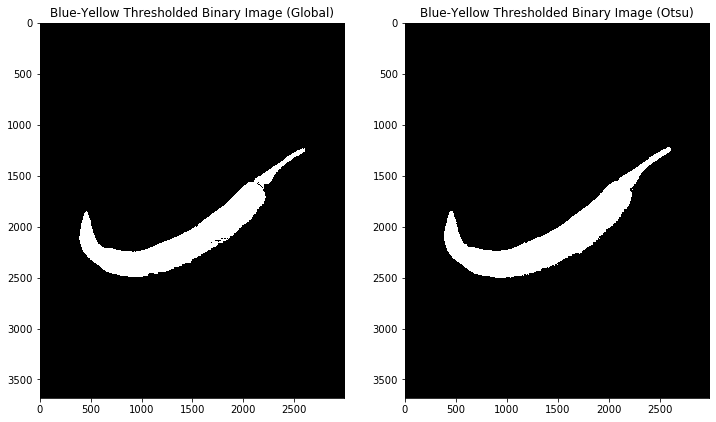

In [7]:
by_blurred = cv.medianBlur(by, 5)
ret, global_thresh = cv.threshold(by_blurred, 132, 255, cv.THRESH_BINARY)
ret, otsu_thresh = cv.threshold(by_blurred, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

plt.figure(figsize=(12, 9))

plt.subplot(121)
plt.title("Blue-Yellow Thresholded Binary Image (Global)")
plt.imshow(global_thresh, cmap='gray')

plt.subplot(122)
plt.title("Blue-Yellow Thresholded Binary Image (Otsu)")
plt.imshow(otsu_thresh, cmap='gray')

plt.show()
by_thresh = global_thresh

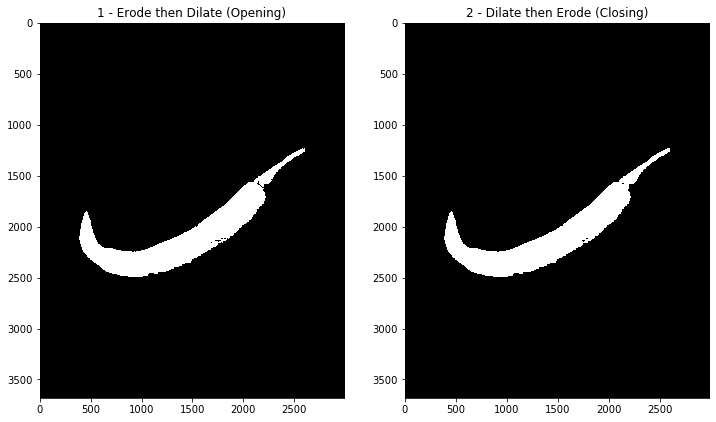

In [8]:
# Noise Removal
kernel = np.ones((5, 5), np.uint8)

opening = cv.morphologyEx(by_thresh, cv.MORPH_OPEN, kernel, iterations=2)
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel, iterations=2)

plt.figure(figsize=(12, 9))

plt.subplot(121)
plt.title("1 - Erode then Dilate (Opening)")
plt.imshow(opening, cmap='gray')

plt.subplot(122)
plt.title("2 - Dilate then Erode (Closing)")
plt.imshow(closing, cmap='gray')

plt.show()

by_final = closing

## Performing the segmentation

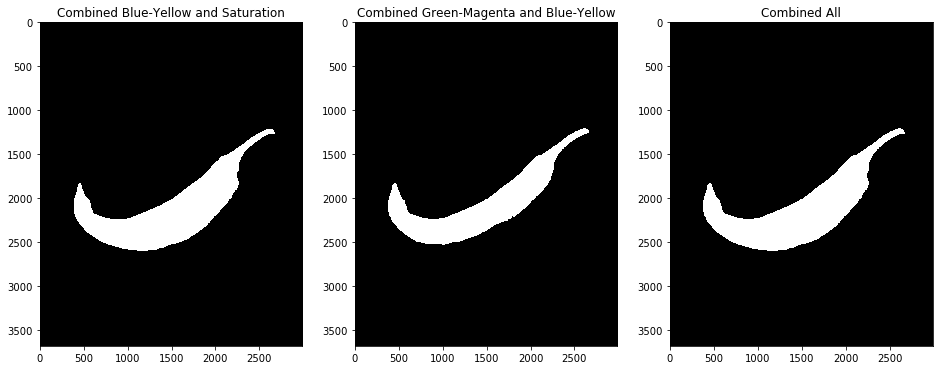

In [9]:
# Combine blue-yellow and saturation channel
# Combine blue-yellow and green-magenta channels

sat_by = cv.bitwise_or(sat_final, by_final)
by_gm = cv.bitwise_or(by_final, gm_final)
sat_by_gm = cv.bitwise_or(sat_by, by_gm)

plt.figure(figsize=(16, 9))

plt.subplot(131)
plt.title("Combined Blue-Yellow and Saturation")
plt.imshow(sat_by, cmap='gray')

plt.subplot(132)
plt.title("Combined Green-Magenta and Blue-Yellow")
plt.imshow(by_gm, cmap='gray')

plt.subplot(133)
plt.title("Combined All")
plt.imshow(sat_by_gm, cmap='gray')

plt.show()

final = sat_by_gm


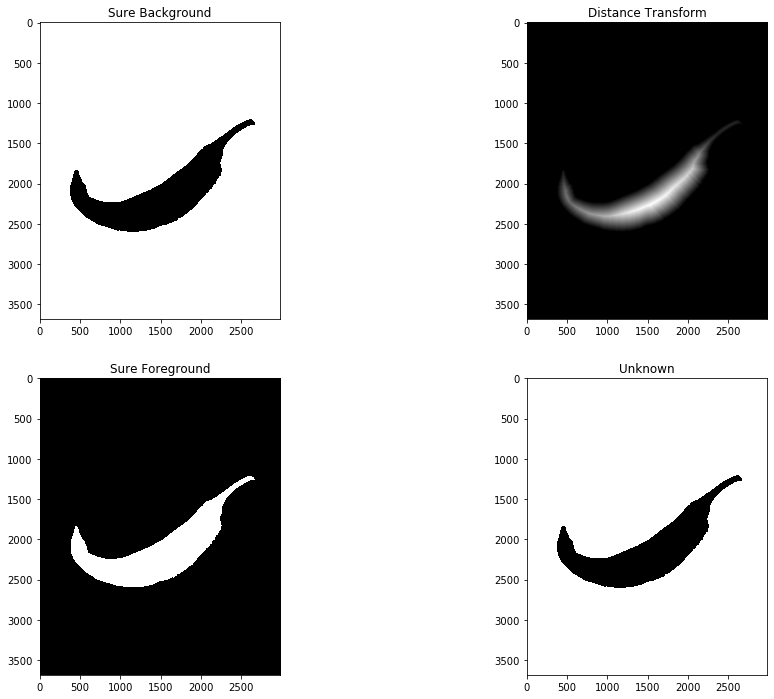

In [10]:
kernel = np.ones((3, 3), np.uint8)

sure_bg = cv.bitwise_not(cv.dilate(final, kernel, iterations=1))

dist_transform = cv.distanceTransform(final, cv.DIST_L2, 3)
ret, sure_fg = cv.threshold(dist_transform, 0.025*dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

plt.figure(figsize=(16, 12))

plt.subplot(221)
plt.title("Sure Background")
plt.imshow(sure_bg, cmap='gray')

plt.subplot(222)
plt.title("Distance Transform")
plt.imshow(dist_transform, cmap='gray')

plt.subplot(223)
plt.title("Sure Foreground")
plt.imshow(sure_fg, cmap='gray')

plt.subplot(224)
plt.title("Unknown")
plt.imshow(unknown, cmap='gray')

plt.show()

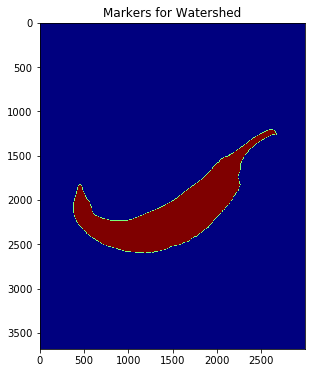

In [11]:
ret, markers = cv.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

plt.figure(figsize=(8, 6))
plt.title("Markers for Watershed")
plt.imshow(markers, cmap='jet')
plt.show()

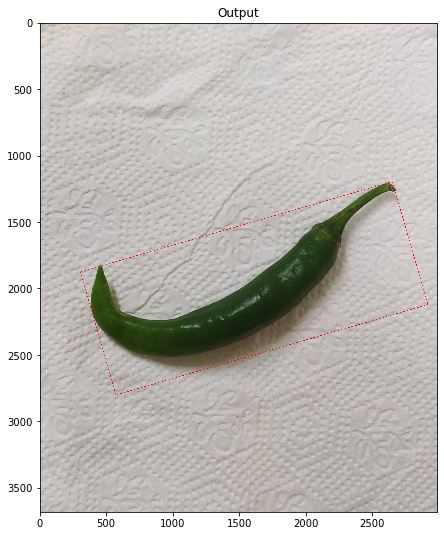

In [12]:
markers = cv.watershed(img, markers)

for marker in np.unique(markers):
    if marker <= 0:
        continue
    
    mask = np.zeros(sat.shape, dtype="uint8")
    mask[markers == marker] = 255
    
    # Detect Contours
    contours = cv.findContours(mask.copy(), cv.RETR_EXTERNAL,
                              cv.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv.contourArea)
    
    # Draw circle
    rotrect = cv.minAreaRect(c)
    box = cv.boxPoints(rotrect)
    box = np.int0(box)
    cv.drawContours(img, [box], 0, (255, 0, 0), 2)
    
plt.figure(figsize=(12, 9))
plt.title("Output")
plt.imshow(img)
plt.show()